This notebook takes points from within the AEM survey area, samples the conductivity model and then interpolates point data onto the AEM layered model
Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import netCDF4
import os
import fiona
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# First we will import the AEM conductivity point line data
# The AEM data is in a netCDF file created from a asci files using geophys_utils
# https://github.com/GeoscienceAustralia/geophys_utils


# Load East Kimberley data
infile  = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf\OrdKeep2019_ModeExp_cor2DLogOrd.nc"
ek_cond = netCDF4.Dataset(infile)

# Create an instance of point utils

cond_point_util = NetCDFPointUtils(ek_cond)

wkt, aem_coords = cond_point_util.utm_coords(cond_point_util.xycoords)

In [4]:
aem_coords

array([[ 430906.00000008, 8293543.99994572],
       [ 430916.40000008, 8293544.99994572],
       [ 430926.80000008, 8293545.99994572],
       ...,
       [ 472486.50000003, 8291890.99994567],
       [ 472474.20000003, 8291895.99994567],
       [ 472461.90000003, 8291899.99994567]])

In [5]:
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Physiography\Soil\Keep_soil_EC_compiled\EK_EC_compiled_completed.csv"
df_EC = pd.read_csv(infile)

df_EC    

,site_id,latitude,longitude,Easting,Northing,Depth_from,Depth_to,EC,units,EC_S/m,source,method
0,RN29517,-15.343860,129.150862,516192.6000,8303635.300,0.00,1.00,42.30000,uS/cm,0.004230,Humphrey's,soil
1,RN29517,-15.343860,129.150862,516192.6000,8303635.300,1.00,2.00,38.40000,uS/cm,0.003840,Humphreys,soil
2,RN29517,-15.343860,129.150862,516192.6000,8303635.300,2.00,3.00,355.00000,uS/cm,0.035500,Humphreys,soil
3,RN29517,-15.343860,129.150862,516192.6000,8303635.300,3.00,4.00,543.00000,uS/cm,0.054300,Humphreys,soil
4,RN29517,-15.343860,129.150862,516192.6000,8303635.300,4.00,5.00,835.00000,uS/cm,0.083500,Humphreys,soil
5,RN29517,-15.343860,129.150862,516192.6000,8303635.300,5.00,6.00,1069.00000,uS/cm,0.106900,Humphreys,soil
6,RN29517,-15.343860,129.150862,516192.6000,8303635.300,6.00,7.00,1501.00000,uS/cm,0.150100,Humphreys,soil
7,RN29517,-15.343860,129.150862,516192.6000,8303635.300,7.00,8.00,1900.00000,uS/cm,0.190000,Humphreys,soil
8,RN29517,-15.343860,129.150862,516192.6000,8303635.300,8.00,9.00,1502.00000,uS/cm,0.150200,Humphreys,soil
9,RN29517,-15.343860,129.150862,516192.6000,8303635.300,9.00,10.00,985.00000,uS/cm,0.098500,Humphreys,soil


In [6]:
df_EC_sites = df_EC.groupby(by='site_id', as_index=False).mean()[['site_id',
                                                                  'Easting', 'Northing']]

In [7]:
# Nearest neighbour search

distances, indices = spatial_functions.nearest_neighbours(df_EC_sites[['Easting', 'Northing']],
                                                         aem_coords, points_required = 10, 
                                                          max_distance = 250.)



In [8]:
# We will save the profiles in a pandas dataframe with a SNMR site key column

df_conductivity = pd.DataFrame(columns = {'site_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity',
                                          'Easting', 'Northing'})

# Iteratively extract the conductivity profiles

for i, (index, row) in enumerate(df_EC_sites.iterrows()):
    
    
    
    # This is a check against null which are returned if the nearest neighbour is further
    # than the maximum distance
    if not np.isnan(distances[i]).all():
        
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                       distances[i],
                                                       indices[i],
                                                       as_dataframe = True)
        # Add the SNMR id to the column
        df_conductivity_profile['site_id'] = row['site_id']
        
        df_conductivity_profile['Easting'] = row['Easting']
        
        df_conductivity_profile['Northing'] = row['Northing']
    
        # Append the site profile to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile, sort = True)
    
df_conductivity.reset_index(inplace=True, drop=True)

In [9]:
#DROp nulls
mask = pd.notnull(df_EC['EC_S/m'])

df_EC = df_EC[mask]

In [10]:
# Iterate through the sites, inteprolate the EC onto the AEM intervals and add them to the dataframe



for site in df_EC['site_id'].unique():
    
    mask = df_EC['site_id'] == site
    
    df_EC_site = df_EC[mask]
    
    mask  = df_conductivity['site_id'] == site
    
    df_cond_site = df_conductivity[mask]
    
    # Interpolate 
    
    df_interpolated = spatial_functions.interpolate_layered_model(df_EC_site, ['EC_S/m'],
                                                                  ['Depth_from', 'Depth_to'],
                                                                  df_cond_site[['Depth_from', 'Depth_to']])
    df_conductivity.at[df_cond_site.index, 'soil_EC'] = df_interpolated['EC_S/m']



c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\spatial_functions.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_intervals[p] = np.nan


In [11]:
df_condEC = df_conductivity[df_conductivity['soil_EC'] != 0]

In [12]:
df_condEC

,Depth_from,Depth_to,Easting,Northing,conductivity,site_id,soil_EC
0,0.00,2.00,515817.6176,8304488.615,0.083160,101,0.016513
19,0.00,2.00,517627.7421,8304597.368,0.159109,107,0.010292
35,0.00,2.00,518982.3641,8305396.331,0.020105,110,0.002976
58,0.00,2.00,514517.9079,8312492.260,0.022552,116,0.003401
82,0.00,2.00,516741.3260,8312650.822,0.064053,118,0.093474
105,0.00,2.00,517299.3238,8312315.386,0.194212,119,0.050957
128,0.00,2.00,517095.3741,8312105.492,0.280191,120,0.070136
150,0.00,2.00,518441.4046,8313874.631,0.135080,126,0.024171
172,0.00,2.00,519247.1451,8313683.958,0.258065,128,0.002976
196,0.00,2.00,519197.5983,8312583.896,0.152718,130,0.059524


In [13]:
mask = df_condEC['Depth_to'] <= 4.04



In [14]:
df_EC

,site_id,latitude,longitude,Easting,Northing,Depth_from,Depth_to,EC,units,EC_S/m,source,method
0,RN29517,-15.343860,129.150862,516192.6000,8303635.300,0.00,1.00,42.30000,uS/cm,0.004230,Humphrey's,soil
1,RN29517,-15.343860,129.150862,516192.6000,8303635.300,1.00,2.00,38.40000,uS/cm,0.003840,Humphreys,soil
2,RN29517,-15.343860,129.150862,516192.6000,8303635.300,2.00,3.00,355.00000,uS/cm,0.035500,Humphreys,soil
3,RN29517,-15.343860,129.150862,516192.6000,8303635.300,3.00,4.00,543.00000,uS/cm,0.054300,Humphreys,soil
4,RN29517,-15.343860,129.150862,516192.6000,8303635.300,4.00,5.00,835.00000,uS/cm,0.083500,Humphreys,soil
5,RN29517,-15.343860,129.150862,516192.6000,8303635.300,5.00,6.00,1069.00000,uS/cm,0.106900,Humphreys,soil
6,RN29517,-15.343860,129.150862,516192.6000,8303635.300,6.00,7.00,1501.00000,uS/cm,0.150100,Humphreys,soil
7,RN29517,-15.343860,129.150862,516192.6000,8303635.300,7.00,8.00,1900.00000,uS/cm,0.190000,Humphreys,soil
8,RN29517,-15.343860,129.150862,516192.6000,8303635.300,8.00,9.00,1502.00000,uS/cm,0.150200,Humphreys,soil
9,RN29517,-15.343860,129.150862,516192.6000,8303635.300,9.00,10.00,985.00000,uS/cm,0.098500,Humphreys,soil


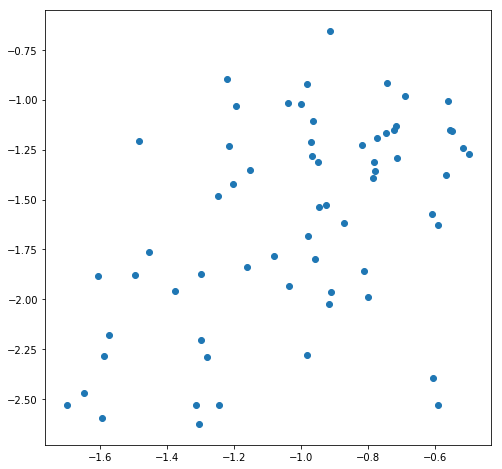

In [15]:
# Scatter plot

fig, ax = plt.subplots(1,1,figsize = (8,8))

ax.scatter(np.log10(df_condEC['conductivity'][mask].values),
          np.log10(df_condEC['soil_EC'][mask].values))

In [17]:
outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\KPTan_EK\Laboratory"
outfile = os.path.join(outdir, "soil_EC_vs_AEM_cond_nomask.csv")
df_condEC.rename(columns={'conductivity':'AEM_bulk_conductivity_S/m'}).to_csv(outfile)

outfile = os.path.join(outdir, "soil_EC_compiled.csv")

#df_EC.to_csv(outfile)